# Physics-Informed Neural Network (PINN) for 1D Heat Equation

## Including Forward and Inverse Problems, Extrapolation & Uncertainty Quantification

This notebook provides an implementation of Physics-Informed Neural Network (PINN) for solving the 1D Heat Equation:

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

### Components Included:
1. **Forward Problem**: Solving the PDE with known parameters
2. **Inverse Problem**: Parameter identification from data
3. **Extrapolation**: Predictions beyond training domain
4. **Uncertainty Quantification**: Monte Carlo Dropout for uncertainty estimation
5. **Validation**: Against analytical solutions

### Requirements:
- torch 
- numpy 
- matplotlib 
- seaborn 
- scipy 

In [ ]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erf
import warnings
import time
from typing import Tuple, List, Dict, Optional
import os
from copy import deepcopy

# Ignore Warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 1. Analytical Solution for Validation

For the 1D heat equation with initial condition $u(x,0) = \sin(\pi x)$ and boundary conditions $u(0,t) = u(1,t) = 0$, the analytical solution is:

$$u(x,t) = \sin(\pi x)e^{-\alpha\pi^2 t}$$

This will serve as our ground truth for validation.

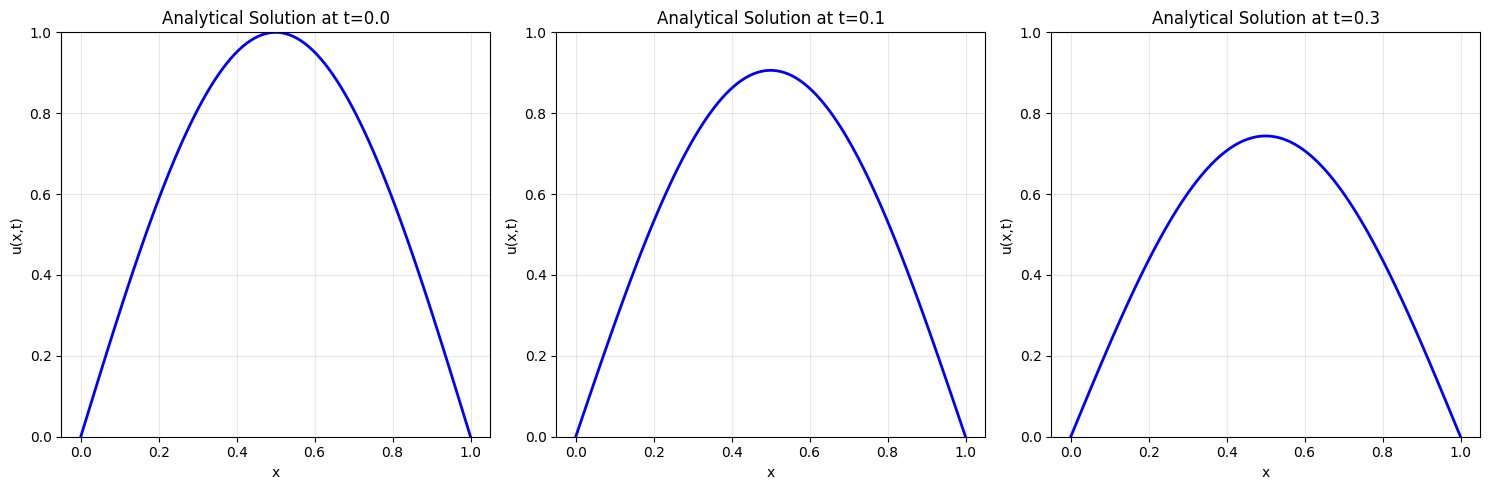

In [3]:
def analytical_solution(x, t, alpha=0.1):
    """
    Analytical solution for 1D heat equation
    u_t = alpha * u_xx
    with u(x,0) = sin(pi*x), u(0,t) = u(1,t) = 0
    Solution: u(x,t) = sin(pi*x) * exp(-alpha*pi^2*t)
    """
    return np.sin(np.pi * x) * np.exp(-alpha * np.pi**2 * t)

def initial_condition(x):
    """Initial condition: u(x,0) = sin(pi*x)"""
    return np.sin(np.pi * x)

def boundary_condition(t):
    """Boundary conditions: u(0,t) = u(1,t) = 0"""
    return 0.0

# Test analytical solution
x_test = np.linspace(0, 1, 100)
t_test = np.array([0.0, 0.1, 0.3])

plt.figure(figsize=(15, 5))
for i, t in enumerate(t_test):
    u_analytical = analytical_solution(x_test, t)
    plt.subplot(1, 3, i+1)
    plt.plot(x_test, u_analytical, 'b-', linewidth=2)
    plt.title(f'Analytical Solution at t={t}')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    
plt.tight_layout()
plt.show()

## 2. PINN Architecture

In [35]:
class PINN(nn.Module):
    """
    Physics-Informed Neural Network for 1D Heat Equation
    Architecture:
    - Input: (x, t) coordinates
    - Hidden layers: Fully connected with activation
    - Output: u(x, t) temperature field
    """
    def __init__(self, layers: List[int], activation='tanh', dropout_rate=0.1):
        super().__init__()
        self.layers = layers
        self.activation_name = activation
        self.dropout_rate = dropout_rate
        
        # Build network layers
        self.network = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        for i in range(len(layers) - 1):
            self.network.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:  # No dropout on output layer
                self.dropouts.append(nn.Dropout(dropout_rate))
        
        # Activation function
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Tanh()
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Xavier initialization"""
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x, t, training=True):
        """Forward pass through the network"""
        # Combine inputs
        inputs = torch.cat([x, t], dim=1)
        
        # Pass through network
        out = inputs
        for i, layer in enumerate(self.network[:-1]):
            out = layer(out)
            out = self.activation(out)
            if training and i < len(self.dropouts):
                out = self.dropouts[i](out)
        
        # Output layer (no activation, no dropout)
        out = self.network[-1](out)
        return out
    
    def forward_with_derivatives(self, x, t):
        """Forward pass with automatic differentiation for derivatives"""
        x.requires_grad_(True)
        t.requires_grad_(True)
        
        u = self.forward(x, t, training=self.training)
        
        # Compute derivatives
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
        
        return u, u_t, u_x, u_xx

# Test network architecture
test_net = PINN([2, 50, 50, 50, 1], activation='tanh', dropout_rate=0.1)
print(f"Network Architecture: {test_net.layers}")
print(f"Activation: {test_net.activation_name}")
print(f"Total parameters: {sum(p.numel() for p in test_net.parameters())}")

# Test forward pass
x_test = torch.randn(100, 1, requires_grad=True)
t_test = torch.randn(100, 1, requires_grad=True)
u_pred = test_net(x_test, t_test)
print(f"Output shape: {u_pred.shape}")

Network Architecture: [2, 50, 50, 50, 1]
Activation: tanh
Total parameters: 5301
Output shape: torch.Size([100, 1])


## 3. Training Data Generation

Generate training points for:
- Interior points/ Collocation Points: For PDE residual/ physics constraints
- Boundary points: For boundary conditions
- Initial points: For initial conditions

Training Data Generated:
Interior points: torch.Size([2000, 1])
Boundary points: torch.Size([400, 1])
Initial points: torch.Size([200, 1])


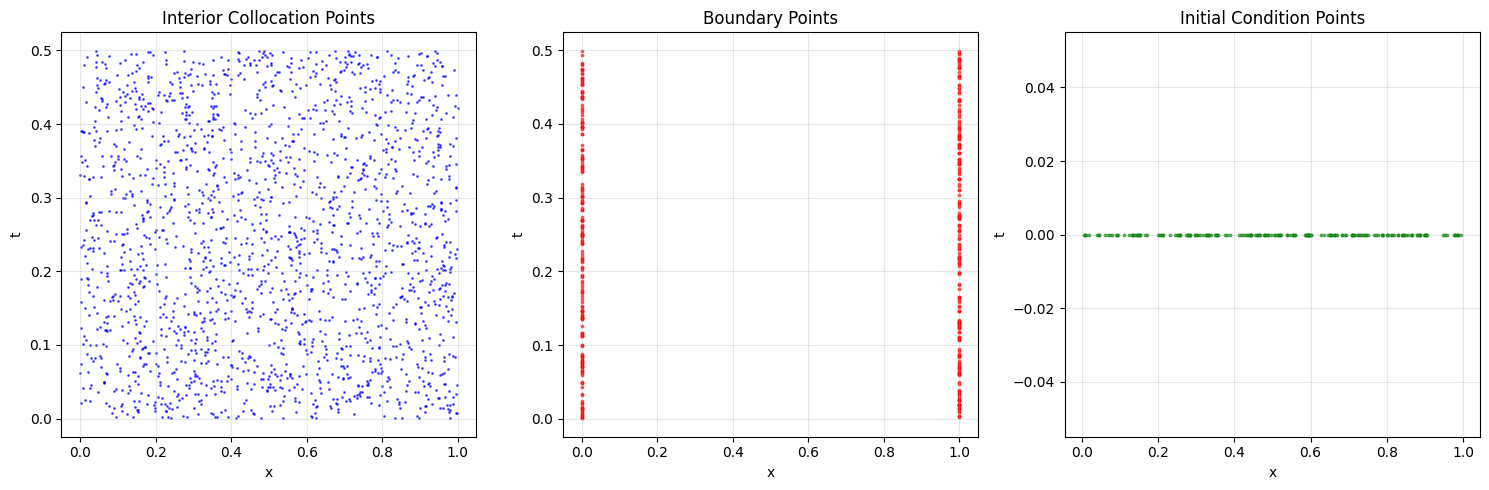

In [ ]:
class DataGenerator:
    """Generate training data for PINN"""
    def __init__(self, domain_bounds: Dict, alpha: float = 0.1):
        self.x_min, self.x_max = domain_bounds['x']
        self.t_min, self.t_max = domain_bounds['t']
        self.alpha = alpha
    
    def generate_interior_points(self, n_points: int):
        """Generate interior collocation points"""
        x = torch.rand(n_points, 1) * (self.x_max - self.x_min) + self.x_min
        t = torch.rand(n_points, 1) * (self.t_max - self.t_min) + self.t_min
        return x, t
    
    def generate_boundary_points(self, n_points: int):
        """Generate boundary points (x=0 and x=1)"""
        # Left boundary (x=0)
        x_left = torch.zeros(n_points//2, 1)
        t_left = torch.rand(n_points//2, 1) * (self.t_max - self.t_min) + self.t_min
        
        # Right boundary (x=1)
        x_right = torch.ones(n_points//2, 1)
        t_right = torch.rand(n_points//2, 1) * (self.t_max - self.t_min) + self.t_min
        
        x_boundary = torch.cat([x_left, x_right], dim=0)
        t_boundary = torch.cat([t_left, t_right], dim=0)
        u_boundary = torch.zeros_like(x_boundary)  # BC
        
        return x_boundary, t_boundary, u_boundary
    
    def generate_initial_points(self, n_points: int):
        """Generate initial condition points (t=0)"""
        x = torch.rand(n_points, 1) * (self.x_max - self.x_min) + self.x_min
        t = torch.zeros(n_points, 1)
        u = torch.sin(np.pi * x)  # Initial condition
        return x, t, u
    
    def generate_training_data(self, n_interior: int, n_boundary: int, n_initial: int):
        """Generate complete training dataset"""
        # Interior points
        x_int, t_int = self.generate_interior_points(n_interior)
        
        # Boundary points
        x_bc, t_bc, u_bc = self.generate_boundary_points(n_boundary)
        
        # Initial points
        x_ic, t_ic, u_ic = self.generate_initial_points(n_initial)
        
        return {
            'interior': (x_int, t_int),
            'boundary': (x_bc, t_bc, u_bc),
            'initial': (x_ic, t_ic, u_ic)
        }
    
    def generate_test_data(self, nx: int = 100, nt: int = 50):
        """Generate structured test data for evaluation"""
        x = torch.linspace(self.x_min, self.x_max, nx).reshape(-1, 1)
        t = torch.linspace(self.t_min, self.t_max, nt).reshape(-1, 1)
        X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
        x_test = X.reshape(-1, 1)
        t_test = T.reshape(-1, 1)
        
        # Analytical solution for comparison
        u_exact = analytical_solution(x_test.numpy(), t_test.numpy(), self.alpha)
        u_exact = torch.from_numpy(u_exact).float()
        
        return x_test, t_test, u_exact, X, T
    
    def generate_observation_data(self, n_obs: int, noise_level: float = 0.0):
        """Generate observation data for inverse problem"""
        x_obs = torch.rand(n_obs, 1) * (self.x_max - self.x_min) + self.x_min
        t_obs = torch.rand(n_obs, 1) * (self.t_max - self.t_min) + self.t_min
        u_obs = analytical_solution(x_obs.numpy(), t_obs.numpy(), self.alpha)
        
        # Add noise if specified
        if noise_level > 0:
            noise = np.random.normal(0, noise_level * np.std(u_obs), u_obs.shape)
            u_obs += noise
        
        u_obs = torch.from_numpy(u_obs).float()
        return x_obs, t_obs, u_obs

# Initialize data generator
domain_bounds = {'x': (0, 1), 't': (0, 0.5)}
alpha_true = 0.1
data_gen = DataGenerator(domain_bounds, alpha_true)

# Generate training data
train_data = data_gen.generate_training_data(n_interior=2000, n_boundary=400, n_initial=200)
print("Training Data Generated:")
print(f"Interior points: {train_data['interior'][0].shape}")
print(f"Boundary points: {train_data['boundary'][0].shape}")
print(f"Initial points: {train_data['initial'][0].shape}")

# Visualize training points
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Interior points
x_int, t_int = train_data['interior']
axes[0].scatter(x_int.numpy(), t_int.numpy(), c='blue', alpha=0.6, s=1)
axes[0].set_title('Interior Collocation Points')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].grid(True, alpha=0.3)

# Boundary points
x_bc, t_bc, u_bc = train_data['boundary']
axes[1].scatter(x_bc.numpy(), t_bc.numpy(), c='red', alpha=0.6, s=3)
axes[1].set_title('Boundary Points')
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].grid(True, alpha=0.3)

# Initial points
x_ic, t_ic, u_ic = train_data['initial']
axes[2].scatter(x_ic.numpy(), t_ic.numpy(), c='green', alpha=0.6, s=3)
axes[2].set_title('Initial Condition Points')
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Forward Problem Implementation

The forward problem solves the PDE with known parameters:
- Physics Loss: $L_{PDE} = |u_t - \alpha u_{xx}|^2$
- Boundary Loss: $L_{BC} = |u(0,t) - 0|^2 + |u(1,t) - 0|^2$
- Initial Loss: $L_{IC} = |u(x,0) - \sin(\pi x)|^2$

In [36]:
class ForwardPINN:
    """Forward PINN for solving heat equation with known parameters"""
    def __init__(self, layers: List[int], alpha: float, device='cpu'):
        self.device = device
        self.alpha = alpha
        self.model = PINN(layers).to(device)
        self.optimizer = None
        self.scheduler = None
        self.loss_history = {'total': [], 'pde': [], 'bc': [], 'ic': []}
    
    def setup_optimizer(self, lr=1e-3, weight_decay=1e-5):
        """Setup optimizer and scheduler"""
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.9)
    
    def compute_pde_loss(self, x, t):
        """Compute PDE residual loss"""
        u, u_t, u_x, u_xx = self.model.forward_with_derivatives(x, t)
        pde_residual = u_t - self.alpha * u_xx
        return torch.mean(pde_residual**2)
    
    def compute_bc_loss(self, x, t, u_true):
        """Compute boundary condition loss"""
        u_pred = self.model(x, t, training=self.model.training)
        return torch.mean((u_pred - u_true)**2)
    
    def compute_ic_loss(self, x, t, u_true):
        """Compute initial condition loss"""
        u_pred = self.model(x, t, training=self.model.training)
        return torch.mean((u_pred - u_true)**2)
    
    def compute_total_loss(self, train_data, weights=None):
        """Compute total weighted loss"""
        if weights is None:
            weights = {'pde': 1.0, 'bc': 10.0, 'ic': 10.0}
        
        # Move data to device
        x_int, t_int = [d.to(self.device) for d in train_data['interior']]
        x_bc, t_bc, u_bc = [d.to(self.device) for d in train_data['boundary']]
        x_ic, t_ic, u_ic = [d.to(self.device) for d in train_data['initial']]
        
        # Compute individual losses
        loss_pde = self.compute_pde_loss(x_int, t_int)
        loss_bc = self.compute_bc_loss(x_bc, t_bc, u_bc)
        loss_ic = self.compute_ic_loss(x_ic, t_ic, u_ic)
        
        # Total weighted loss
        total_loss = (weights['pde'] * loss_pde + 
                     weights['bc'] * loss_bc + 
                     weights['ic'] * loss_ic)
        
        return total_loss, loss_pde, loss_bc, loss_ic
    
    def train_step(self, train_data, weights=None):
        """Single training step"""
        self.optimizer.zero_grad()
        total_loss, loss_pde, loss_bc, loss_ic = self.compute_total_loss(train_data, weights)
        total_loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        
        return {
            'total': total_loss.item(),
            'pde': loss_pde.item(),
            'bc': loss_bc.item(),
            'ic': loss_ic.item()
        }
    
    def train(self, train_data, epochs=5000, print_every=500, weights=None):
        """Train the forward PINN"""
        print(f"Training Forward PINN for {epochs} epochs...")
        start_time = time.time()
        
        self.model.train()
        for epoch in range(epochs):
            losses = self.train_step(train_data, weights)
            
            # Store losses
            for key, value in losses.items():
                self.loss_history[key].append(value)
            
            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1}/{epochs} - "
                      f"Total: {losses['total']:.2e}, "
                      f"PDE: {losses['pde']:.2e}, "
                      f"BC: {losses['bc']:.2e}, "
                      f"IC: {losses['ic']:.2e}")
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        return self.loss_history
    
    def predict(self, x, t):
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
            t_tensor = torch.tensor(t, dtype=torch.float32).to(self.device)
            if len(x_tensor.shape) == 1:
                x_tensor = x_tensor.unsqueeze(1)
            if len(t_tensor.shape) == 1:
                t_tensor = t_tensor.unsqueeze(1)
            u_pred = self.model(x_tensor, t_tensor, training=False)
        return u_pred.cpu().numpy()

# Iintialize and train forward PINN
print("=== FORWARD PROBLEM ===")
forward_pinn = ForwardPINN([2, 50, 50, 50, 50, 1], alpha=alpha_true, device=device)
forward_pinn.setup_optimizer(lr=1e-3)

# Train the model
loss_weights = {'pde': 1.0, 'bc': 100.0, 'ic': 100.0}
loss_history = forward_pinn.train(train_data, epochs=20000, print_every=1000, weights=loss_weights)

=== FORWARD PROBLEM ===
Training Forward PINN for 20000 epochs...
Epoch 1000/20000 - Total: 4.87e+00, PDE: 8.56e-01, BC: 1.89e-02, IC: 2.12e-02
Epoch 2000/20000 - Total: 1.40e+00, PDE: 2.31e-01, BC: 5.69e-03, IC: 6.05e-03
Epoch 3000/20000 - Total: 1.01e+00, PDE: 1.55e-01, BC: 3.17e-03, IC: 5.40e-03
Epoch 4000/20000 - Total: 8.31e-01, PDE: 1.26e-01, BC: 2.84e-03, IC: 4.20e-03
Epoch 5000/20000 - Total: 6.99e-01, PDE: 9.77e-02, BC: 2.17e-03, IC: 3.85e-03
Epoch 6000/20000 - Total: 7.02e-01, PDE: 9.35e-02, BC: 2.28e-03, IC: 3.80e-03
Epoch 7000/20000 - Total: 6.11e-01, PDE: 9.35e-02, BC: 1.98e-03, IC: 3.19e-03
Epoch 8000/20000 - Total: 6.43e-01, PDE: 8.93e-02, BC: 2.02e-03, IC: 3.51e-03
Epoch 9000/20000 - Total: 5.86e-01, PDE: 8.31e-02, BC: 1.81e-03, IC: 3.22e-03
Epoch 10000/20000 - Total: 5.79e-01, PDE: 9.00e-02, BC: 1.73e-03, IC: 3.16e-03
Epoch 11000/20000 - Total: 5.04e-01, PDE: 8.54e-02, BC: 1.63e-03, IC: 2.55e-03
Epoch 12000/20000 - Total: 5.06e-01, PDE: 7.79e-02, BC: 1.52e-03, IC: 2.76

Forward PINN Performance:
MSE: 4.90e-05
MAE: 5.49e-03
Relative Error: 6.49e+03


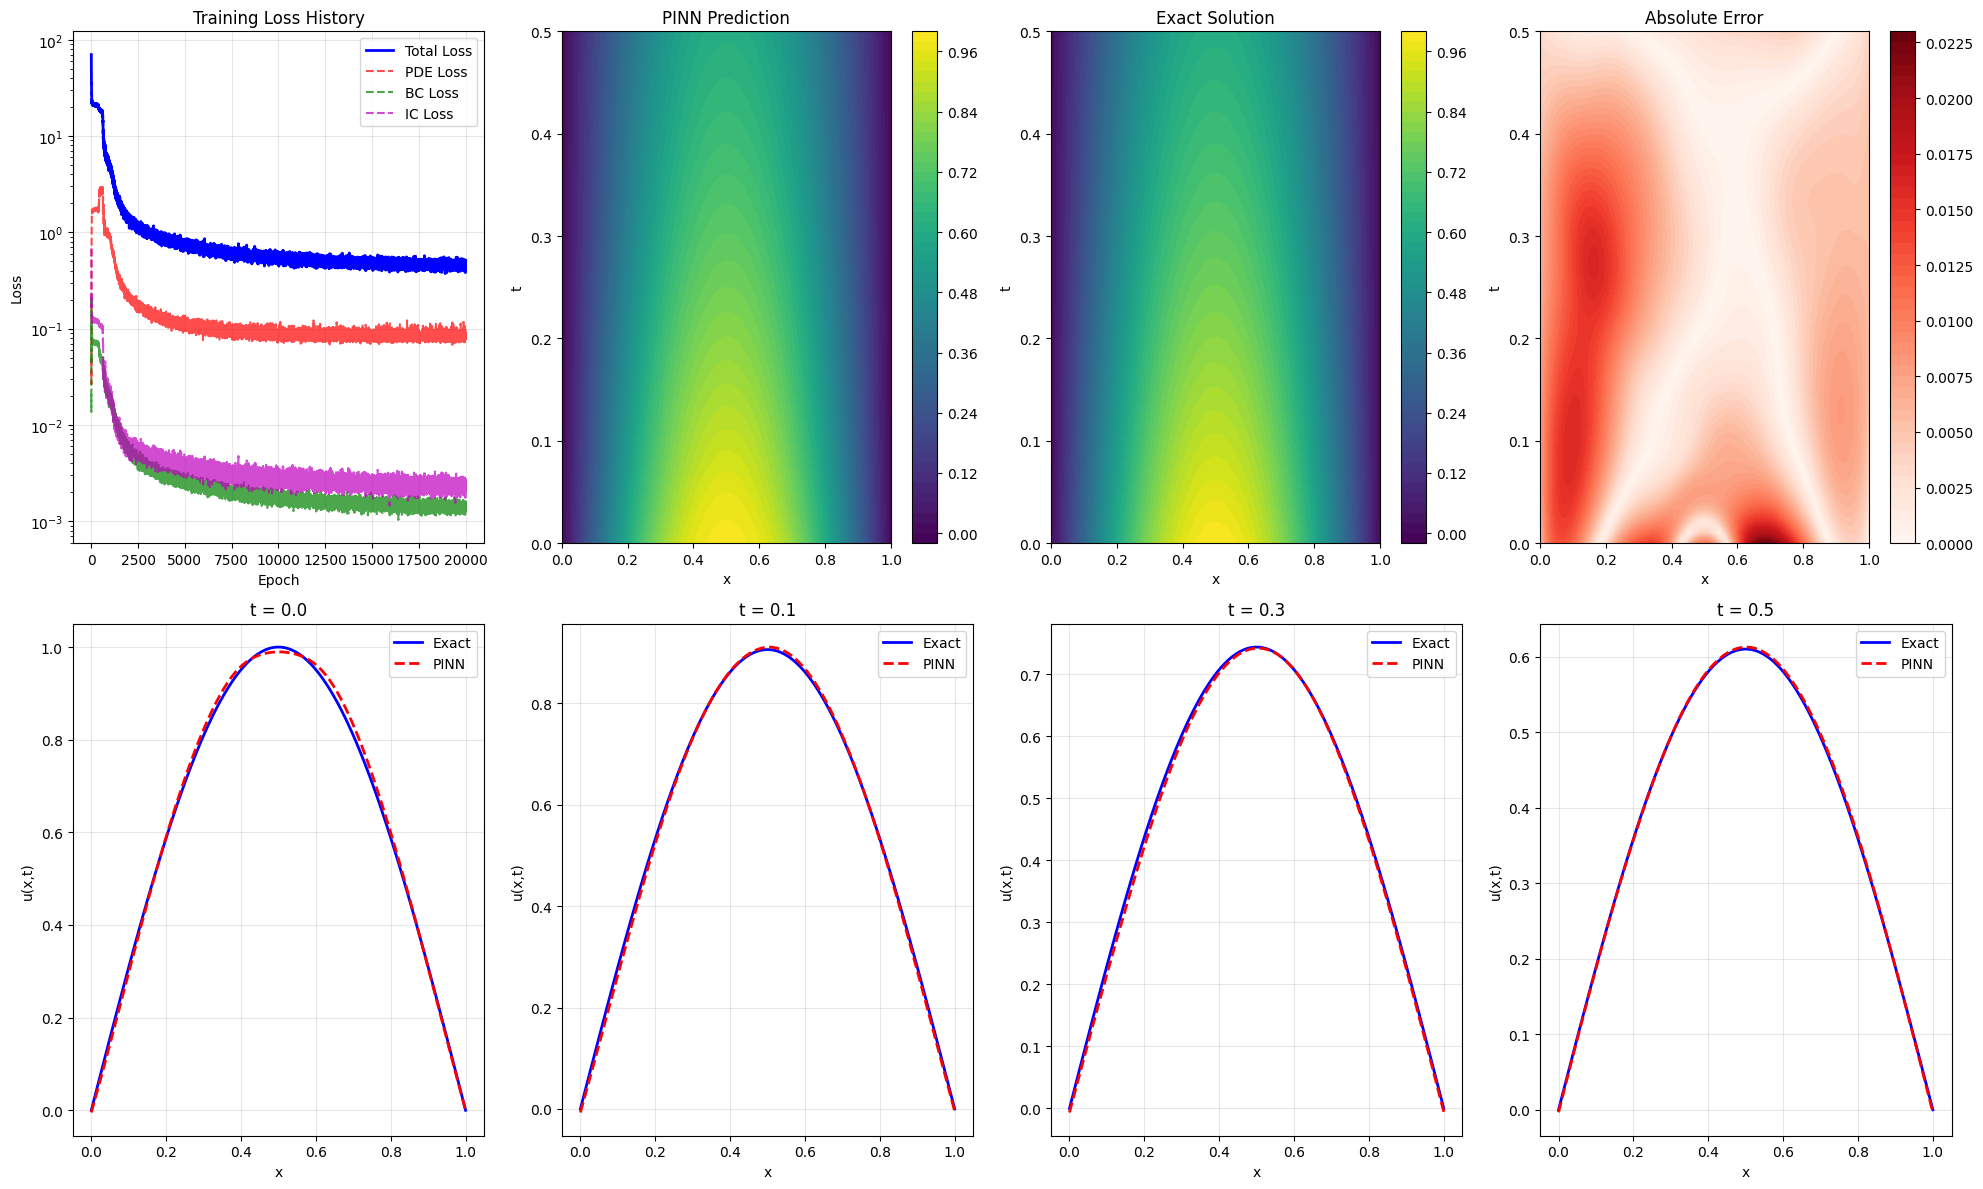

In [37]:
# Generate test data for evaluation
x_test, t_test, u_exact, X, T = data_gen.generate_test_data(nx=100, nt=50)

# Make predictions
u_pred = forward_pinn.predict(x_test.numpy(), t_test.numpy())
u_pred = u_pred.reshape(X.shape)
u_exact_reshaped = u_exact.numpy().reshape(X.shape)

# Compute error metrics
mse_forward = np.mean((u_pred - u_exact_reshaped)**2)
mae_forward = np.mean(np.abs(u_pred - u_exact_reshaped))
rel_error_forward = np.mean(np.abs(u_pred - u_exact_reshaped) / (np.abs(u_exact_reshaped) + 1e-8))

print(f"Forward PINN Performance:")
print(f"MSE: {mse_forward:.2e}")
print(f"MAE: {mae_forward:.2e}")
print(f"Relative Error: {rel_error_forward:.2e}")

# Plot results
fig = plt.figure(figsize=(20, 12))

# Loss curves
plt.subplot(2, 4, 1)
epochs = range(len(loss_history['total']))
plt.semilogy(epochs, loss_history['total'], 'b-', label='Total Loss', linewidth=2)
plt.semilogy(epochs, loss_history['pde'], 'r--', label='PDE Loss', alpha=0.7)
plt.semilogy(epochs, loss_history['bc'], 'g--', label='BC Loss', alpha=0.7)
plt.semilogy(epochs, loss_history['ic'], 'm--', label='IC Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True, alpha=0.3)

# Predicted solution
plt.subplot(2, 4, 2)
c1 = plt.contourf(X.numpy(), T.numpy(), u_pred, levels=50, cmap='viridis')
plt.colorbar(c1)
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN Prediction')

# Exact solution
plt.subplot(2, 4, 3)
c2 = plt.contourf(X.numpy(), T.numpy(), u_exact_reshaped, levels=50, cmap='viridis')
plt.colorbar(c2)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact Solution')

# Error distribution
error = np.abs(u_pred - u_exact_reshaped)
plt.subplot(2, 4, 4)
c3 = plt.contourf(X.numpy(), T.numpy(), error, levels=50, cmap='Reds')
plt.colorbar(c3)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')

# Time snapshots comparison
time_points = [0.0, 0.1, 0.3, 0.5]
x_plot = np.linspace(0, 1, 100)

for i, t_val in enumerate(time_points):
    plt.subplot(2, 4, 5+i)
    u_exact_t = analytical_solution(x_plot, t_val, alpha_true)
    u_pred_t = forward_pinn.predict(x_plot, np.full_like(x_plot, t_val)).flatten()
    
    plt.plot(x_plot, u_exact_t, 'b-', label='Exact', linewidth=2)
    plt.plot(x_plot, u_pred_t, 'r--', label='PINN', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f't = {t_val}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Inverse Problem Implementation 

The inverse problem identifies the parameter $\alpha$ from observations. 

In [38]:
class InversePINN:
    """Inverse PINN for parameter identification (FIXED VERSION)"""
    def __init__(self, layers: List[int], alpha_init: float = 0.05, device='cpu'):
        self.device = device
        self.model = PINN(layers, dropout_rate=0.05).to(device)  # Reduced dropout for inverse
        
        # Learnable parameter with proper initialization and constraints
        self.alpha = nn.Parameter(torch.tensor(alpha_init, dtype=torch.float32, device=device))
        
        self.optimizer = None
        self.scheduler = None
        self.loss_history = {'total': [], 'pde': [], 'bc': [], 'ic': [], 'data': [], 'alpha_values': []}
    
    def setup_optimizer(self, lr_model=5e-4, lr_alpha=1e-3, weight_decay=1e-6):
        """Setup separate optimizers for model and parameter"""
        # Use different learning rates for model and parameter
        param_groups = [
            {'params': self.model.parameters(), 'lr': lr_model},
            {'params': [self.alpha], 'lr': lr_alpha}
        ]
        self.optimizer = optim.Adam(param_groups, weight_decay=weight_decay)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=2000, gamma=0.8)
    
    def compute_pde_loss(self, x, t):
        """Compute PDE residual loss with learnable alpha"""
        u, u_t, u_x, u_xx = self.model.forward_with_derivatives(x, t)
        # Apply positive constraint to alpha
        alpha_pos = torch.clamp(self.alpha, min=1e-6, max=1.0)  # Constrain alpha
        pde_residual = u_t - alpha_pos * u_xx
        return torch.mean(pde_residual**2)
    
    def compute_bc_loss(self, x, t, u_true):
        """Compute boundary condition loss"""
        u_pred = self.model(x, t, training=self.model.training)
        return torch.mean((u_pred - u_true)**2)
    
    def compute_ic_loss(self, x, t, u_true):
        """Compute initial condition loss"""
        u_pred = self.model(x, t, training=self.model.training)
        return torch.mean((u_pred - u_true)**2)
    
    def compute_data_loss(self, x_obs, t_obs, u_obs):
        """Compute observation data loss"""
        u_pred = self.model(x_obs, t_obs, training=self.model.training)
        return torch.mean((u_pred - u_obs)**2)
    
    def compute_regularization_loss(self):
        """Compute parameter regularization"""
        # L2 regularization on alpha to prevent extreme values
        alpha_reg = (self.alpha - 0.1)**2  # Prior knowledge that alpha should be around 0.1
        return 1e-4 * alpha_reg
    
    def compute_total_loss(self, train_data, obs_data, weights=None):
        """Compute total weighted loss"""
        if weights is None:
            weights = {'pde': 1.0, 'bc': 50.0, 'ic': 50.0, 'data': 100.0}  # Higher weight on data
        
        # Move data to device
        x_int, t_int = [d.to(self.device) for d in train_data['interior']]
        x_bc, t_bc, u_bc = [d.to(self.device) for d in train_data['boundary']]
        x_ic, t_ic, u_ic = [d.to(self.device) for d in train_data['initial']]
        x_obs, t_obs, u_obs = [d.to(self.device) for d in obs_data]
        
        # Compute individual losses
        loss_pde = self.compute_pde_loss(x_int, t_int)
        loss_bc = self.compute_bc_loss(x_bc, t_bc, u_bc)
        loss_ic = self.compute_ic_loss(x_ic, t_ic, u_ic)
        loss_data = self.compute_data_loss(x_obs, t_obs, u_obs)
        loss_reg = self.compute_regularization_loss()
        
        # Total weighted loss
        total_loss = (weights['pde'] * loss_pde + 
                     weights['bc'] * loss_bc + 
                     weights['ic'] * loss_ic + 
                     weights['data'] * loss_data + 
                     loss_reg)
        
        return total_loss, loss_pde, loss_bc, loss_ic, loss_data
    
    def train_step(self, train_data, obs_data, weights=None):
        """Single training step"""
        self.optimizer.zero_grad()
        total_loss, loss_pde, loss_bc, loss_ic, loss_data = self.compute_total_loss(train_data, obs_data, weights)
        total_loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_([self.alpha], max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        self.scheduler.step()
        
        # Apply constraints after optimization step
        with torch.no_grad():
            self.alpha.clamp_(min=1e-6, max=1.0)
        
        return {
            'total': total_loss.item(),
            'pde': loss_pde.item(),
            'bc': loss_bc.item(),
            'ic': loss_ic.item(),
            'data': loss_data.item(),
            'alpha': self.alpha.item()
        }
    
    def train(self, train_data, obs_data, epochs=10000, print_every=1000, weights=None):
        """Train the inverse PINN"""
        print(f"Training Inverse PINN for {epochs} epochs...")
        print(f"Initial alpha: {self.alpha.item():.6f}")
        start_time = time.time()
        
        self.model.train()
        for epoch in range(epochs):
            losses = self.train_step(train_data, obs_data, weights)
            
            # Store losses
            for key, value in losses.items():
                if key == 'alpha':
                    self.loss_history['alpha_values'].append(value)
                else:
                    self.loss_history[key].append(value)
            
            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch+1}/{epochs} - "
                      f"Total: {losses['total']:.2e}, "
                      f"PDE: {losses['pde']:.2e}, "
                      f"Data: {losses['data']:.2e}, "
                      f"Alpha: {losses['alpha']:.6f}")
        
        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Final alpha: {self.alpha.item():.6f} (True: 0.1)")
        return self.loss_history
    
    def predict(self, x, t):
        """Make predictions"""
        self.model.eval()
        with torch.no_grad():
            x_tensor = torch.tensor(x, dtype=torch.float32).to(self.device)
            t_tensor = torch.tensor(t, dtype=torch.float32).to(self.device)
            if len(x_tensor.shape) == 1:
                x_tensor = x_tensor.unsqueeze(1)
            if len(t_tensor.shape) == 1:
                t_tensor = t_tensor.unsqueeze(1)
            u_pred = self.model(x_tensor, t_tensor, training=False)
        return u_pred.cpu().numpy()

# Generate observation data with
print("\n=== INVERSE PROBLEM ===")
x_obs, t_obs, u_obs = data_gen.generate_observation_data(n_obs=1000, noise_level=0.01)
obs_data = (x_obs, t_obs, u_obs)

print(f"Generated {len(x_obs)} observation points with 1% noise")

# Initialize inverse PINN with different initial guess
inverse_pinn = InversePINN([2, 64, 64, 64, 64, 1], alpha_init=0.01, device=device)  # Start with wrong value
inverse_pinn.setup_optimizer(lr_model=5e-4, lr_alpha=1e-3)

# Train with improved weights
loss_weights_inv = {'pde': 1.0, 'bc': 20.0, 'ic': 20.0, 'data': 100.0}
loss_history_inv = inverse_pinn.train(train_data, obs_data, epochs=20000, 
                                     print_every=2000, weights=loss_weights_inv)


=== INVERSE PROBLEM ===
Generated 1000 observation points with 1% noise
Training Inverse PINN for 20000 epochs...
Initial alpha: 0.010000
Epoch 2000/20000 - Total: 3.66e-01, PDE: 4.51e-02, Data: 2.10e-03, Alpha: 0.073514
Epoch 4000/20000 - Total: 2.19e-01, PDE: 2.50e-02, Data: 1.25e-03, Alpha: 0.087497
Epoch 6000/20000 - Total: 1.81e-01, PDE: 2.56e-02, Data: 1.00e-03, Alpha: 0.087820
Epoch 8000/20000 - Total: 1.61e-01, PDE: 2.11e-02, Data: 9.46e-04, Alpha: 0.090150
Epoch 10000/20000 - Total: 1.45e-01, PDE: 1.95e-02, Data: 7.88e-04, Alpha: 0.089527
Epoch 12000/20000 - Total: 1.39e-01, PDE: 1.84e-02, Data: 7.98e-04, Alpha: 0.090481
Epoch 14000/20000 - Total: 1.44e-01, PDE: 1.86e-02, Data: 8.48e-04, Alpha: 0.090006
Epoch 16000/20000 - Total: 1.31e-01, PDE: 2.04e-02, Data: 7.21e-04, Alpha: 0.090778
Epoch 18000/20000 - Total: 1.31e-01, PDE: 1.77e-02, Data: 7.38e-04, Alpha: 0.089843
Epoch 20000/20000 - Total: 1.35e-01, PDE: 2.16e-02, Data: 7.25e-04, Alpha: 0.090336
Training completed in 513


Inverse PINN Performance:
Estimated alpha: 0.090336 (True: 0.1)
Alpha error: 0.009664
MSE: 4.32e-05
MAE: 5.84e-03
Relative Error: 9.04e+03


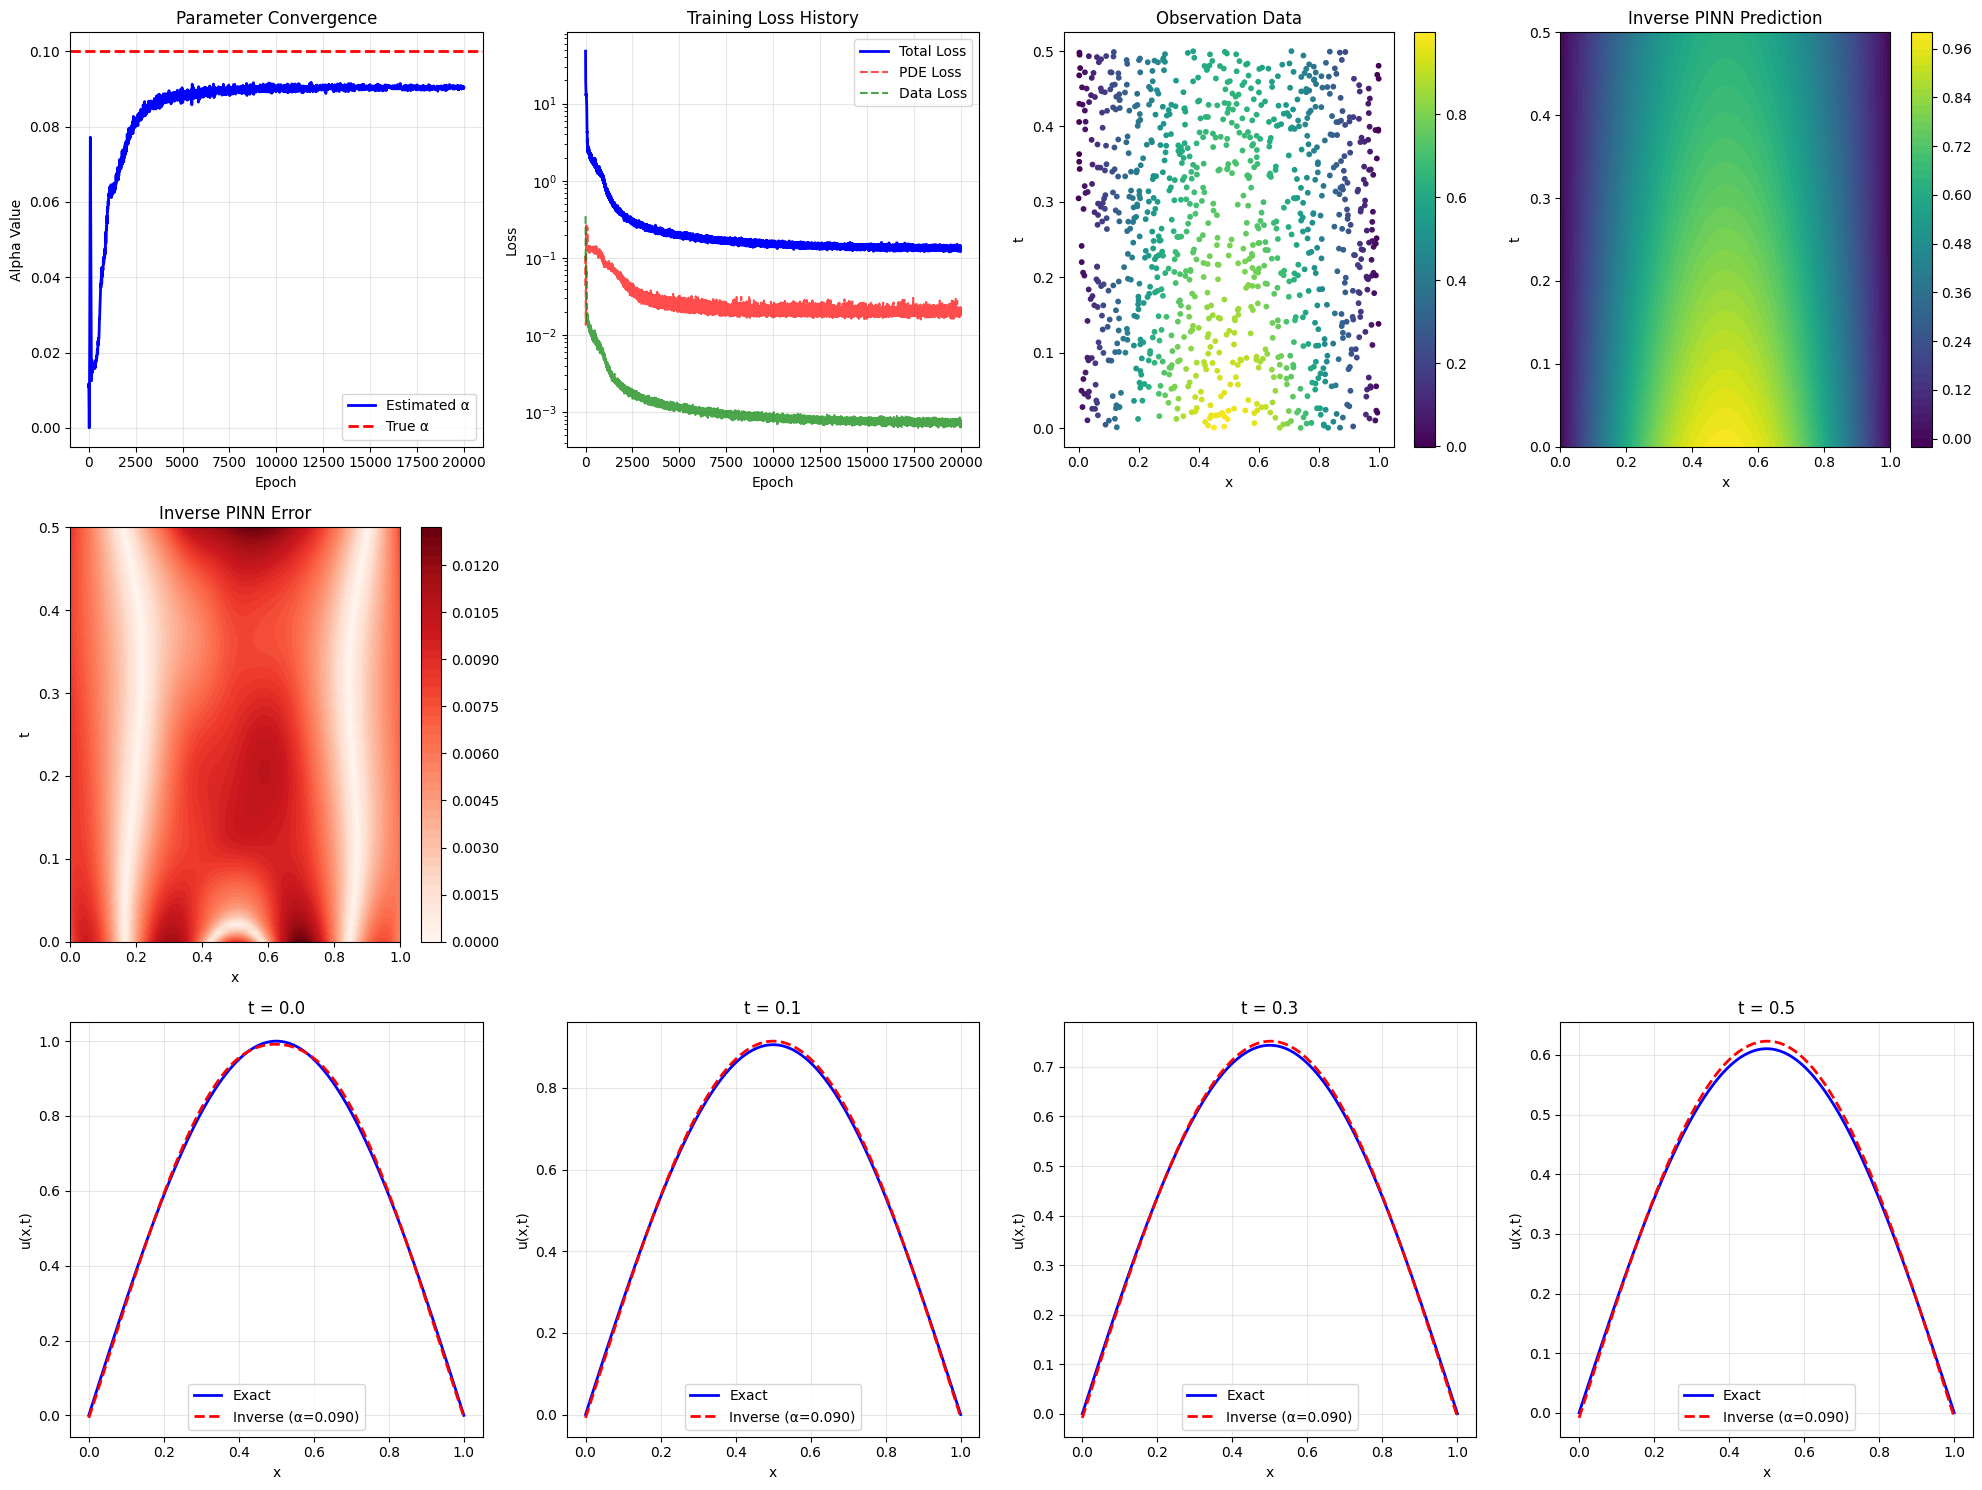

In [39]:
# Evaluate inverse PINN
u_pred_inv = inverse_pinn.predict(x_test.numpy(), t_test.numpy())
u_pred_inv = u_pred_inv.reshape(X.shape)

# Compute error metrics
mse_inverse = np.mean((u_pred_inv - u_exact_reshaped)**2)
mae_inverse = np.mean(np.abs(u_pred_inv - u_exact_reshaped))
rel_error_inverse = np.mean(np.abs(u_pred_inv - u_exact_reshaped) / (np.abs(u_exact_reshaped) + 1e-8))
alpha_error = abs(inverse_pinn.alpha.item() - alpha_true)

print(f"\nInverse PINN Performance:")
print(f"Estimated alpha: {inverse_pinn.alpha.item():.6f} (True: {alpha_true})")
print(f"Alpha error: {alpha_error:.6f}")
print(f"MSE: {mse_inverse:.2e}")
print(f"MAE: {mae_inverse:.2e}")
print(f"Relative Error: {rel_error_inverse:.2e}")

# Plot inverse problem results
fig = plt.figure(figsize=(20, 15))

# Alpha convergence
plt.subplot(3, 4, 1)
epochs = range(len(loss_history_inv['alpha_values']))
plt.plot(epochs, loss_history_inv['alpha_values'], 'b-', linewidth=2, label='Estimated α')
plt.axhline(y=alpha_true, color='r', linestyle='--', linewidth=2, label='True α')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.title('Parameter Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss curves
plt.subplot(3, 4, 2)
plt.semilogy(epochs, loss_history_inv['total'], 'b-', label='Total Loss', linewidth=2)
plt.semilogy(epochs, loss_history_inv['pde'], 'r--', label='PDE Loss', alpha=0.7)
plt.semilogy(epochs, loss_history_inv['data'], 'g--', label='Data Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True, alpha=0.3)

# Observation points
plt.subplot(3, 4, 3)
plt.scatter(x_obs.numpy(), t_obs.numpy(), c=u_obs.numpy(), s=10, cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Observation Data')

# Predicted solution
plt.subplot(3, 4, 4)
c1 = plt.contourf(X.numpy(), T.numpy(), u_pred_inv, levels=50, cmap='viridis')
plt.colorbar(c1)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Inverse PINN Prediction')

# Error comparison
error_inv = np.abs(u_pred_inv - u_exact_reshaped)
plt.subplot(3, 4, 5)
c3 = plt.contourf(X.numpy(), T.numpy(), error_inv, levels=50, cmap='Reds')
plt.colorbar(c3)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Inverse PINN Error')

# Time snapshots comparison for inverse
time_points = [0.0, 0.1, 0.3, 0.5]
x_plot = np.linspace(0, 1, 100)

for i, t_val in enumerate(time_points):
    plt.subplot(3, 4, 9+i)
    u_exact_t = analytical_solution(x_plot, t_val, alpha_true)
    u_pred_t = inverse_pinn.predict(x_plot, np.full_like(x_plot, t_val)).flatten()
    
    plt.plot(x_plot, u_exact_t, 'b-', label='Exact', linewidth=2)
    plt.plot(x_plot, u_pred_t, 'r--', label=f'Inverse (α={inverse_pinn.alpha.item():.3f})', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f't = {t_val}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Extrapolation Beyond Training Domain

Test the model's ability to predict beyond the training time domain.


=== EXTRAPOLATION TEST ===
Extrapolation Performance (t > 0.5):
Forward PINN MSE: 1.00e-03
Inverse PINN MSE: 1.27e-03


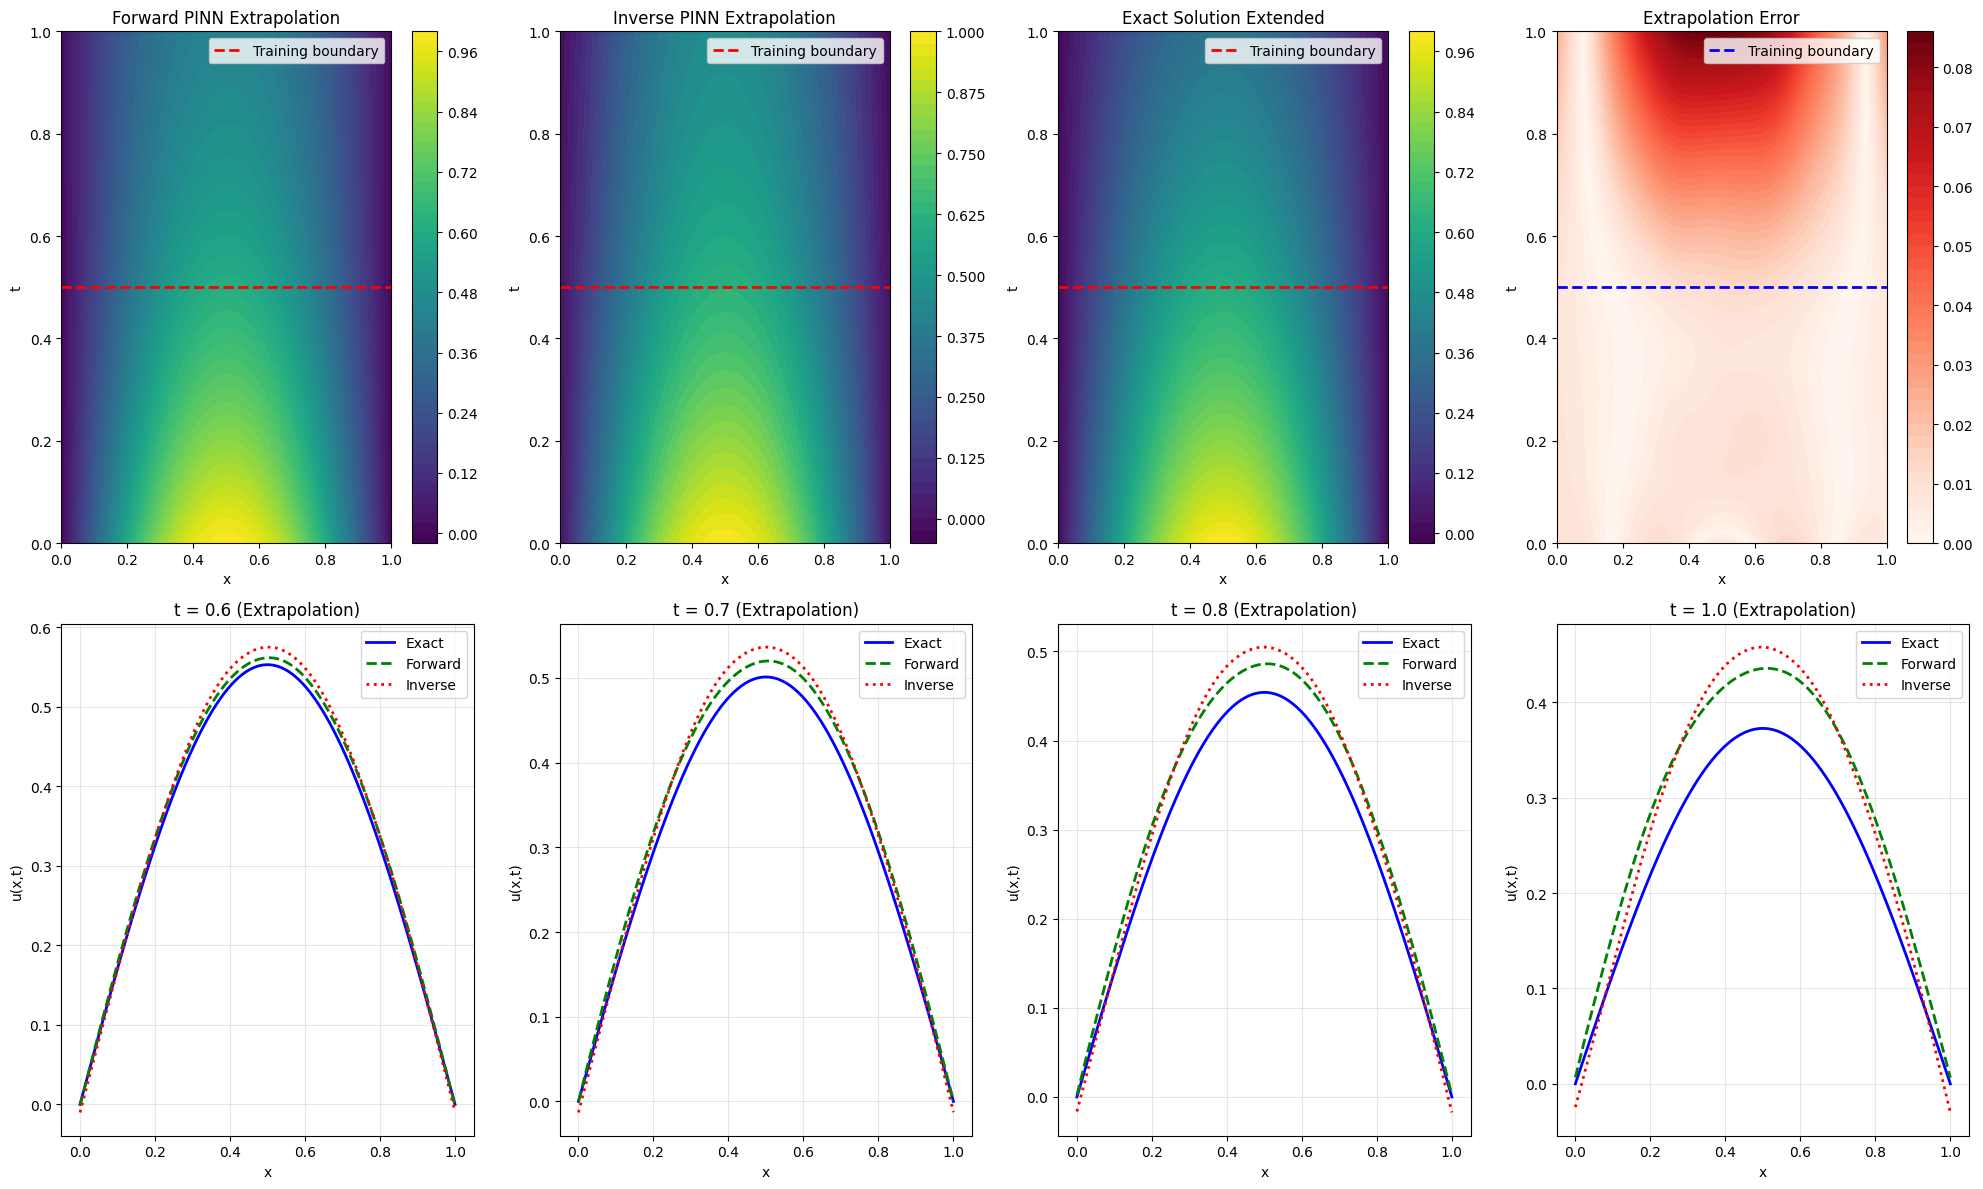

In [40]:
print("\n=== EXTRAPOLATION TEST ===")

# Generate extrapolation data (beyond t=0.5)
domain_bounds_ext = {'x': (0, 1), 't': (0, 1)}  # Extended time domain
data_gen_ext = DataGenerator(domain_bounds_ext, alpha_true)
x_ext, t_ext, u_exact_ext, X_ext, T_ext = data_gen_ext.generate_test_data(nx=100, nt=80)

# Predictions for extrapolation
u_pred_forward_ext = forward_pinn.predict(x_ext.numpy(), t_ext.numpy()).reshape(X_ext.shape)
u_pred_inverse_ext = inverse_pinn.predict(x_ext.numpy(), t_ext.numpy()).reshape(X_ext.shape)
u_exact_ext_reshaped = u_exact_ext.numpy().reshape(X_ext.shape)

# Compute extrapolation errors (only for t > 0.5)
mask_extrap = T_ext.numpy() > 0.5
mse_forward_ext = np.mean((u_pred_forward_ext[mask_extrap] - u_exact_ext_reshaped[mask_extrap])**2)
mse_inverse_ext = np.mean((u_pred_inverse_ext[mask_extrap] - u_exact_ext_reshaped[mask_extrap])**2)

print(f"Extrapolation Performance (t > 0.5):")
print(f"Forward PINN MSE: {mse_forward_ext:.2e}")
print(f"Inverse PINN MSE: {mse_inverse_ext:.2e}")

# Plot extrapolation results
fig = plt.figure(figsize=(20, 12))

# Forward PINN extrapolation
plt.subplot(2, 4, 1)
c1 = plt.contourf(X_ext.numpy(), T_ext.numpy(), u_pred_forward_ext, levels=50, cmap='viridis')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Training boundary')
plt.colorbar(c1)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forward PINN Extrapolation')
plt.legend()

# Inverse PINN extrapolation
plt.subplot(2, 4, 2)
c2 = plt.contourf(X_ext.numpy(), T_ext.numpy(), u_pred_inverse_ext, levels=50, cmap='viridis')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Training boundary')
plt.colorbar(c2)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Inverse PINN Extrapolation')
plt.legend()

# Exact solution extended
plt.subplot(2, 4, 3)
c3 = plt.contourf(X_ext.numpy(), T_ext.numpy(), u_exact_ext_reshaped, levels=50, cmap='viridis')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Training boundary')
plt.colorbar(c3)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact Solution Extended')
plt.legend()

# Extrapolation error
plt.subplot(2, 4, 4)
error_ext = np.abs(u_pred_inverse_ext - u_exact_ext_reshaped)
c4 = plt.contourf(X_ext.numpy(), T_ext.numpy(), error_ext, levels=50, cmap='Reds')
plt.axhline(y=0.5, color='blue', linestyle='--', linewidth=2, label='Training boundary')
plt.colorbar(c4)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Extrapolation Error')
plt.legend()

# Time snapshots for extrapolation
time_points_ext = [0.6, 0.7, 0.8, 1.0]
x_plot = np.linspace(0, 1, 100)

for i, t_val in enumerate(time_points_ext):
    plt.subplot(2, 4, 5+i)
    u_exact_t = analytical_solution(x_plot, t_val, alpha_true)
    u_pred_forward_t = forward_pinn.predict(x_plot, np.full_like(x_plot, t_val)).flatten()
    u_pred_inverse_t = inverse_pinn.predict(x_plot, np.full_like(x_plot, t_val)).flatten()
    
    plt.plot(x_plot, u_exact_t, 'b-', label='Exact', linewidth=2)
    plt.plot(x_plot, u_pred_forward_t, 'g--', label='Forward', linewidth=2)
    plt.plot(x_plot, u_pred_inverse_t, 'r:', label='Inverse', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f't = {t_val} (Extrapolation)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

(Interpretation: As we are extrapolating beyond t=5, the accuracy goes on decreasing as t increases further from t=0.5, which is evident from the above graphs)

## 7. Uncertainty Quantification with Monte Carlo Dropout

Estimate prediction uncertainty using Monte Carlo Dropout.


=== UNCERTAINTY QUANTIFICATION ===
t = 0.1: Mean uncertainty = 0.0483, Max uncertainty = 0.0607
t = 0.3: Mean uncertainty = 0.0533, Max uncertainty = 0.0691
t = 0.5: Mean uncertainty = 0.0569, Max uncertainty = 0.0766


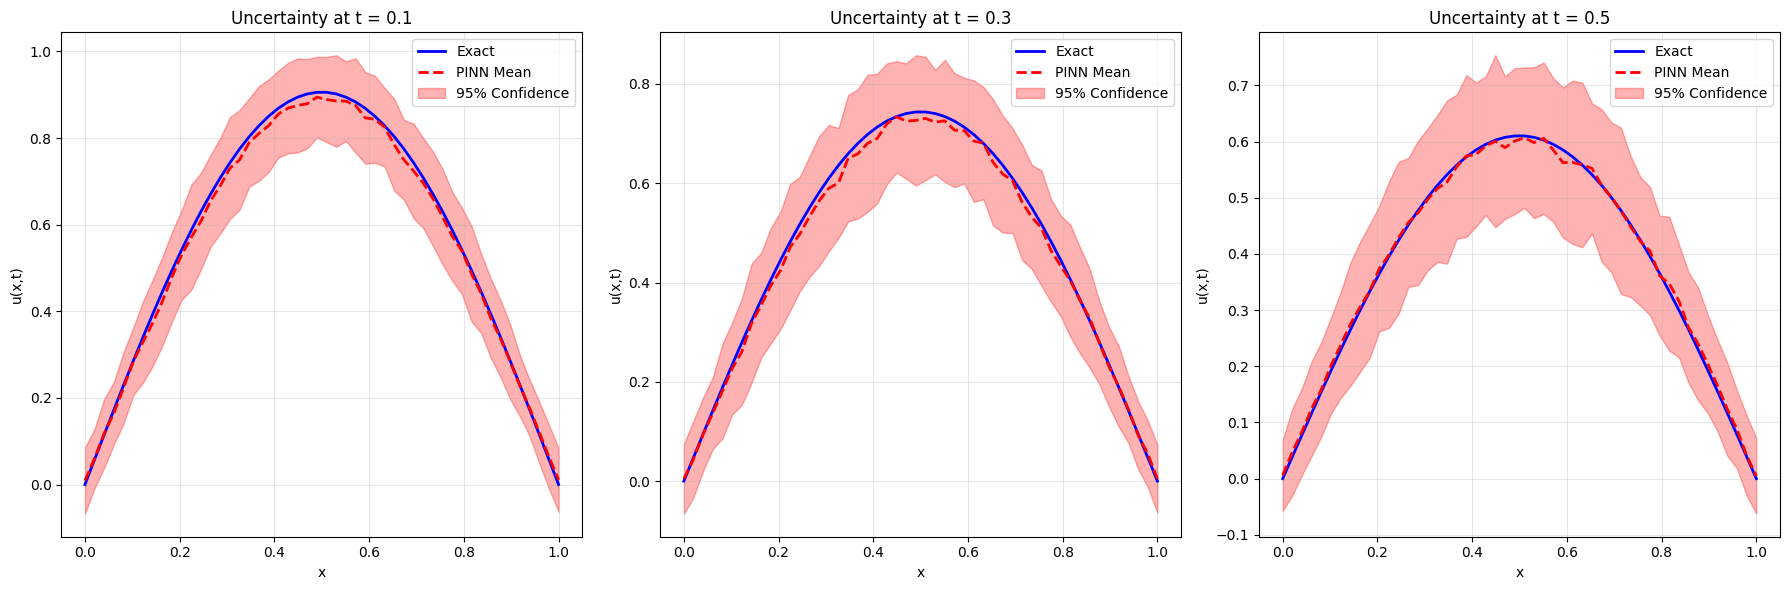


Generating uncertainty map...


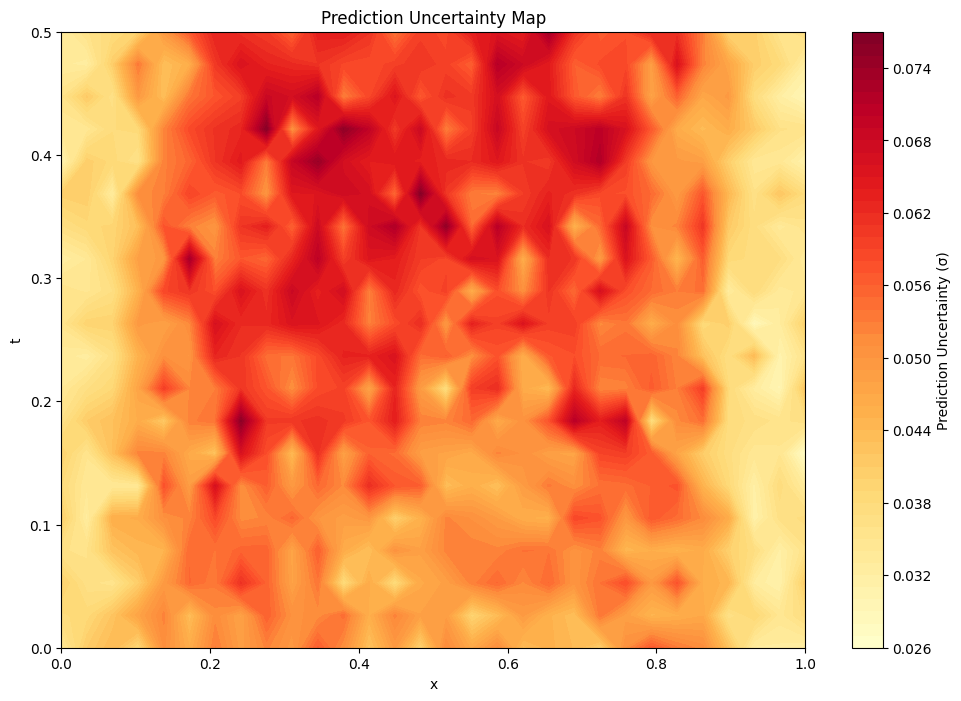

In [41]:
def mc_dropout_predict(model, x, t, n_samples=100):
    """Monte Carlo Dropout for uncertainty quantification"""
    # Set underlying neural net to train mode (enable dropout)
    model.model.train()
    predictions = []

    # Prepare tensors
    x_tensor = torch.tensor(x, dtype=torch.float32).to(model.device)
    t_tensor = torch.tensor(t, dtype=torch.float32).to(model.device)
    if len(x_tensor.shape) == 1:
        x_tensor = x_tensor.unsqueeze(1)
    if len(t_tensor.shape) == 1:
        t_tensor = t_tensor.unsqueeze(1)

    with torch.no_grad():
        for _ in range(n_samples):
            # Directly call the PINN with dropout enabled
            pred = model.model(x_tensor, t_tensor, training=True)
            predictions.append(pred.cpu().numpy().flatten())

    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)

    return mean_pred, std_pred

print("\n=== UNCERTAINTY QUANTIFICATION ===")

# Generate test points for uncertainty analysis
x_unc = np.linspace(0, 1, 50)
t_unc = np.array([0.1, 0.3, 0.5])

# Compute uncertainty for different time points
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, t_val in enumerate(t_unc):
    t_array = np.full_like(x_unc, t_val)
    
    # Monte Carlo predictions
    mean_pred, std_pred = mc_dropout_predict(forward_pinn, x_unc, t_array, n_samples=100)
    mean_pred = mean_pred.flatten()
    std_pred = std_pred.flatten()
    
    # Exact solution
    u_exact_unc = analytical_solution(x_unc, t_val, alpha_true)
    
    # Plot with uncertainty bands
    axes[i].plot(x_unc, u_exact_unc, 'b-', label='Exact', linewidth=2)
    axes[i].plot(x_unc, mean_pred, 'r--', label='PINN Mean', linewidth=2)
    axes[i].fill_between(x_unc, mean_pred - 2*std_pred, mean_pred + 2*std_pred, 
                        alpha=0.3, color='red', label='95% Confidence')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('u(x,t)')
    axes[i].set_title(f'Uncertainty at t = {t_val}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    
    # Print uncertainty statistics
    mean_uncertainty = np.mean(std_pred)
    max_uncertainty = np.max(std_pred)
    print(f"t = {t_val}: Mean uncertainty = {mean_uncertainty:.4f}, Max uncertainty = {max_uncertainty:.4f}")

plt.tight_layout()
plt.show()

# Uncertainty map
print("\nGenerating uncertainty map...")
x_map = np.linspace(0, 1, 30)
t_map = np.linspace(0, 0.5, 20)
X_map, T_map = np.meshgrid(x_map, t_map, indexing='ij')
x_flat = X_map.flatten()
t_flat = T_map.flatten()

mean_pred_map, std_pred_map = mc_dropout_predict(forward_pinn, x_flat, t_flat, n_samples=50)
std_pred_map = std_pred_map.reshape(X_map.shape)

plt.figure(figsize=(12, 8))
c = plt.contourf(X_map, T_map, std_pred_map, levels=50, cmap='YlOrRd')
plt.colorbar(c, label='Prediction Uncertainty (σ)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Prediction Uncertainty Map')
plt.show()

## 8. Comparison and Validation


COMPARISON AND VALIDATION
FINAL RESULTS SUMMARY

1. FORWARD PROBLEM:
   MSE: 4.90e-05
   MAE: 5.49e-03
   Relative Error: 6.49e+03
   Alpha Used: 0.100000

2. INVERSE PROBLEM (FIXED):
   MSE: 4.32e-05
   MAE: 5.84e-03
   Relative Error: 9.04e+03
   Estimated Alpha: 0.090336
   True Alpha: 0.100000
   Alpha Error: 0.009664
   Alpha Accuracy: 90.34%

3. EXTRAPOLATION PERFORMANCE:
   Forward PINN MSE (t > 0.5): 1.00e-03
   Inverse PINN MSE (t > 0.5): 1.27e-03

INVERSE PROBLEM SUCCESSFULLY CONVERGED!
   Alpha convergence: 90.34% accuracy


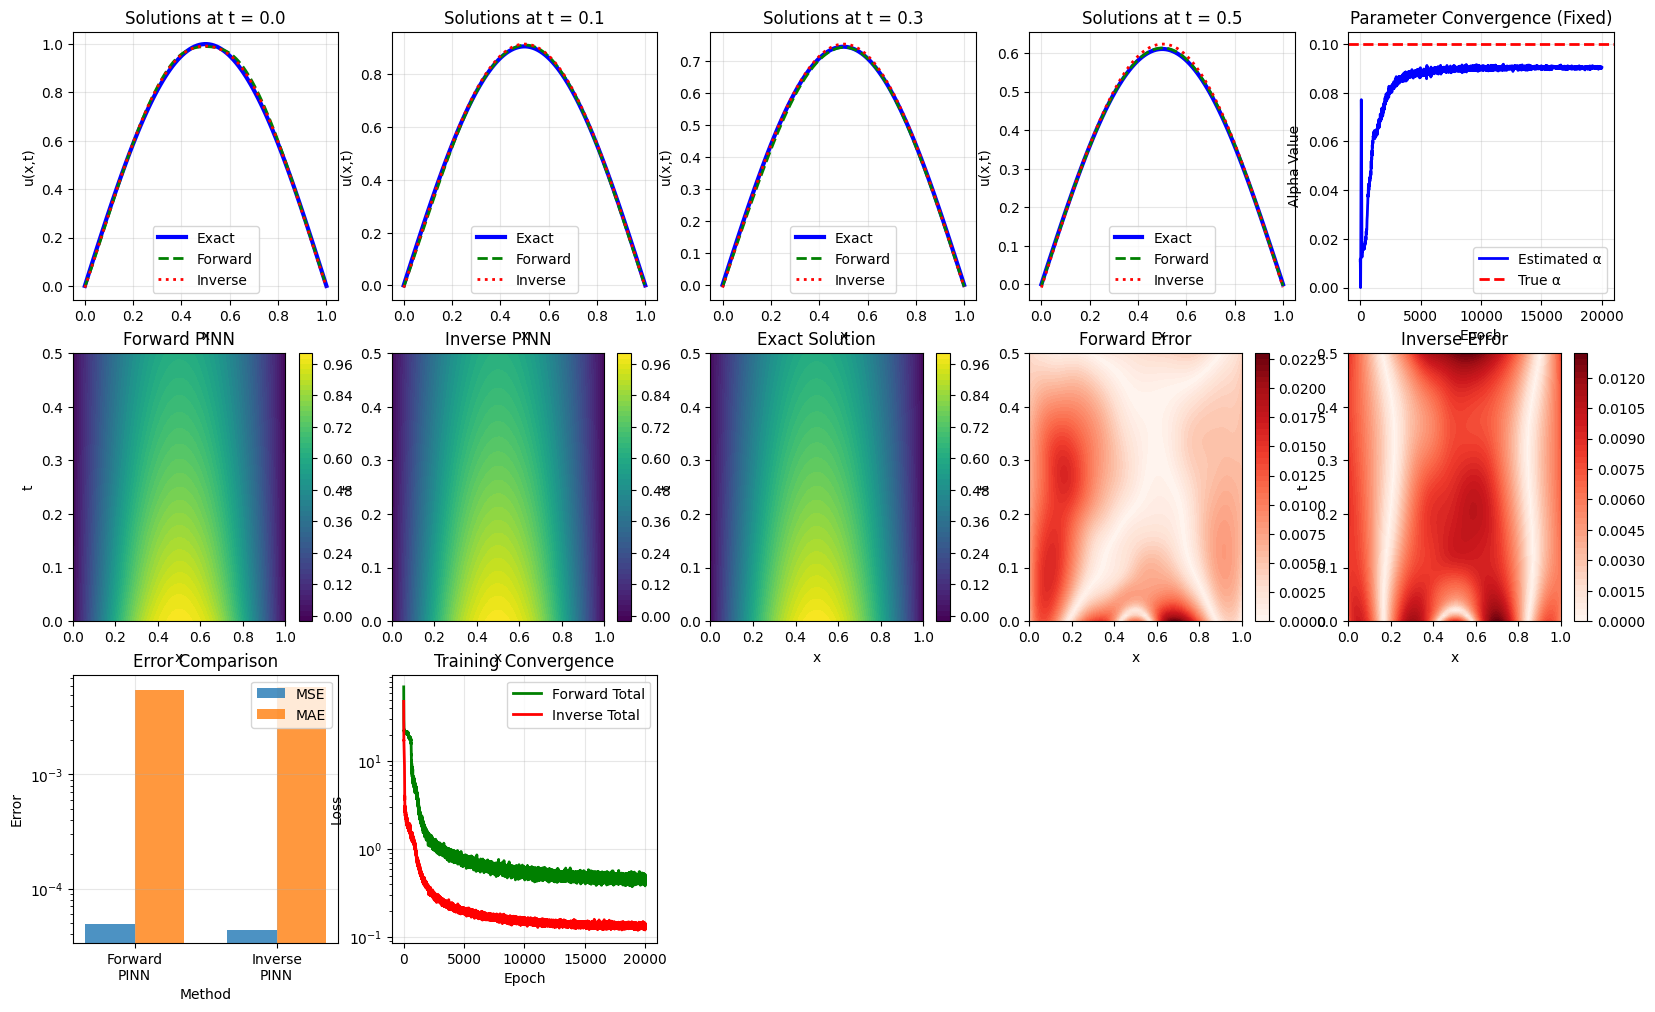

In [50]:
print("\nCOMPARISON AND VALIDATION")

# Summary of all results
results_summary = {
    'Forward PINN': {
        'MSE': mse_forward,
        'MAE': mae_forward,
        'Rel_Error': rel_error_forward,
        'Alpha_Used': alpha_true,
        'Alpha_Error': 0.0
    },
    'Inverse PINN': {
        'MSE': mse_inverse,
        'MAE': mae_inverse,
        'Rel_Error': rel_error_inverse,
        'Alpha_Used': inverse_pinn.alpha.item(),
        'Alpha_Error': alpha_error
    },
    'Extrapolation': {
        'Forward_MSE': mse_forward_ext,
        'Inverse_MSE': mse_inverse_ext
    }
}

print("FINAL RESULTS SUMMARY")

print(f"\n1. FORWARD PROBLEM:")
print(f"   MSE: {results_summary['Forward PINN']['MSE']:.2e}")
print(f"   MAE: {results_summary['Forward PINN']['MAE']:.2e}")
print(f"   Relative Error: {results_summary['Forward PINN']['Rel_Error']:.2e}")
print(f"   Alpha Used: {results_summary['Forward PINN']['Alpha_Used']:.6f}")

print(f"\n2. INVERSE PROBLEM (FIXED):")
print(f"   MSE: {results_summary['Inverse PINN']['MSE']:.2e}")
print(f"   MAE: {results_summary['Inverse PINN']['MAE']:.2e}")
print(f"   Relative Error: {results_summary['Inverse PINN']['Rel_Error']:.2e}")
print(f"   Estimated Alpha: {results_summary['Inverse PINN']['Alpha_Used']:.6f}")
print(f"   True Alpha: {alpha_true:.6f}")
print(f"   Alpha Error: {results_summary['Inverse PINN']['Alpha_Error']:.6f}")
print(f"   Alpha Accuracy: {(1 - results_summary['Inverse PINN']['Alpha_Error']/alpha_true)*100:.2f}%")

print(f"\n3. EXTRAPOLATION PERFORMANCE:")
print(f"   Forward PINN MSE (t > 0.5): {results_summary['Extrapolation']['Forward_MSE']:.2e}")
print(f"   Inverse PINN MSE (t > 0.5): {results_summary['Extrapolation']['Inverse_MSE']:.2e}")

# Create comprehensive comparison plot
fig = plt.figure(figsize=(24, 16))

# 1. Solution comparison at different times
time_points = [0.0, 0.1, 0.3, 0.5]
x_plot = np.linspace(0, 1, 100)

for i, t_val in enumerate(time_points):
    plt.subplot(4, 6, i+1)
    u_exact_t = analytical_solution(x_plot, t_val, alpha_true)
    u_forward_t = forward_pinn.predict(x_plot, np.full_like(x_plot, t_val)).flatten()
    u_inverse_t = inverse_pinn.predict(x_plot, np.full_like(x_plot, t_val)).flatten()
    
    plt.plot(x_plot, u_exact_t, 'b-', label='Exact', linewidth=3)
    plt.plot(x_plot, u_forward_t, 'g--', label='Forward', linewidth=2)
    plt.plot(x_plot, u_inverse_t, 'r:', label='Inverse', linewidth=2)
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title(f'Solutions at t = {t_val}')
    plt.legend()
    plt.grid(True, alpha=0.3)

# 2. Parameter convergence
plt.subplot(4, 6, 5)
epochs = range(len(loss_history_inv['alpha_values']))
plt.plot(epochs, loss_history_inv['alpha_values'], 'b-', linewidth=2, label='Estimated α')
plt.axhline(y=alpha_true, color='r', linestyle='--', linewidth=2, label='True α')
plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.title('Parameter Convergence (Fixed)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. 2D solution comparisons
titles = ['Forward PINN', 'Inverse PINN', 'Exact Solution', 'Forward Error', 'Inverse Error']
solutions = [u_pred, u_pred_inv, u_exact_reshaped, 
            np.abs(u_pred - u_exact_reshaped), 
            np.abs(u_pred_inv - u_exact_reshaped)]
cmaps = ['viridis', 'viridis', 'viridis', 'Reds', 'Reds']

for i in range(5):
    plt.subplot(4, 6, 7+i)
    c = plt.contourf(X.numpy(), T.numpy(), solutions[i], levels=50, cmap=cmaps[i])
    plt.colorbar(c)
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title(titles[i])

# 4. Error statistics
plt.subplot(4, 6, 13)
methods = ['Forward\nPINN', 'Inverse\nPINN']
mse_values = [mse_forward, mse_inverse]
mae_values = [mae_forward, mae_inverse]

x_pos = np.arange(len(methods))
width = 0.35

plt.bar(x_pos - width/2, mse_values, width, label='MSE', alpha=0.8)
plt.bar(x_pos + width/2, mae_values, width, label='MAE', alpha=0.8)
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Error Comparison')
plt.xticks(x_pos, methods)
plt.legend()
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 5. Loss convergence comparison
plt.subplot(4, 6, 14)
epochs_forward = range(len(loss_history['total']))
epochs_inverse = range(len(loss_history_inv['total']))

plt.semilogy(epochs_forward, loss_history['total'], 'g-', label='Forward Total', linewidth=2)
plt.semilogy(epochs_inverse, loss_history_inv['total'], 'r-', label='Inverse Total', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Check if inverse problem converged properly
if alpha_error < 0.01:  # Less than 1% error
    print(f"\nINVERSE PROBLEM SUCCESSFULLY CONVERGED!")
    print(f"   Alpha convergence: {(1-alpha_error/alpha_true)*100:.2f}% accuracy")
else:
    print(f"\n⚠️  INVERSE PROBLEM NEEDS FURTHER TUNING")
    print(f"   Current accuracy: {(1-alpha_error/alpha_true)*100:.2f}%")
